# <h1> SIR_Model</h1> </div>

# About this project

### This notebook analyses the relationship of measures against COVID-19 (Coronavirus disease 2019) and the number of infected cases. The goal is to find measures that enable us to settle the situation more quickly.

We have used <b>SIR and SEIR</b> where in SEIR model that is a customized ODE model derived from SIR model. To evaluate the effect of measures, parameter estimation of SIR is applied to subsets of time series data . Parameter change points is determined by S-R trend analysis.

Our code gets the real time data from <a href= "https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data"> JHU</a> and gives live results. Though We were given california as our state but Weave tried to make our code dynamic and by entering places mentioned in the list it is possible to track COVID-19 situation of that place as well.

# Links to various sections. 

# Dataset and tools
    
* I have used Python language to make this project

    
* Libraries used:
    * Numpy
    * Pandas
    * matplotlib.pyplot
    * SciPy
    * Plotly
    
    
* <a href= "https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data">I have used JHU CSSE Covid - 19 Dataset</a>

* ## Dataset details

As mentioned before We have used JHU CSSE Covid - 19 Dataset. We have made a script <tt>'master_data.py'</tt> that updates our database from the website, cleans it and adds an approximated number of patients recovered in the state. Please find the script in the files, its self explanatory. The script can download and clean the data of any state, however We have currently set it to California.

In [1]:
population = 40_000_000
state = "California"

* ## Dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

# Please remeber that the data of csv file has been read as 'raw_data' variable
raw_data = pd.read_csv('data.csv')

raw_data['date'] = pd.to_datetime(raw_data.date)
raw_data.tail(10)

,Unnamed: 0,state,date,cases_confirmed,total_deaths,new_deaths,total_US_deaths,death_ratio,total_US_rec,approx_state_rec_total
143,143,California,2020-06-13,150018,5076,98,115436,0.043972,556606,24475.0
144,144,California,2020-06-14,152300,5099,23,115732,0.044059,561816,24753.0
145,145,California,2020-06-15,155726,5114,15,116127,0.044038,576334,25381.0
146,146,California,2020-06-16,158961,5200,86,116963,0.044459,583503,25942.0
147,147,California,2020-06-17,162798,5271,71,117717,0.044777,592191,26516.0
148,148,California,2020-06-18,167086,5355,84,118432,0.045216,599115,27089.0
149,149,California,2020-06-19,170862,5426,71,119124,0.045549,606715,27635.0
150,150,California,2020-06-20,175213,5494,68,119719,0.045891,617460,28336.0
151,151,California,2020-06-21,178546,5515,21,119977,0.045967,622133,28598.0
152,152,California,2020-06-22,184765,5566,51,120402,0.046228,640198,29595.0


### Plotting the data we have

We have plotted the data in the 'data.csv' file. Please scale and zoom the graph to view better.

<IPython.core.display.Javascript object>


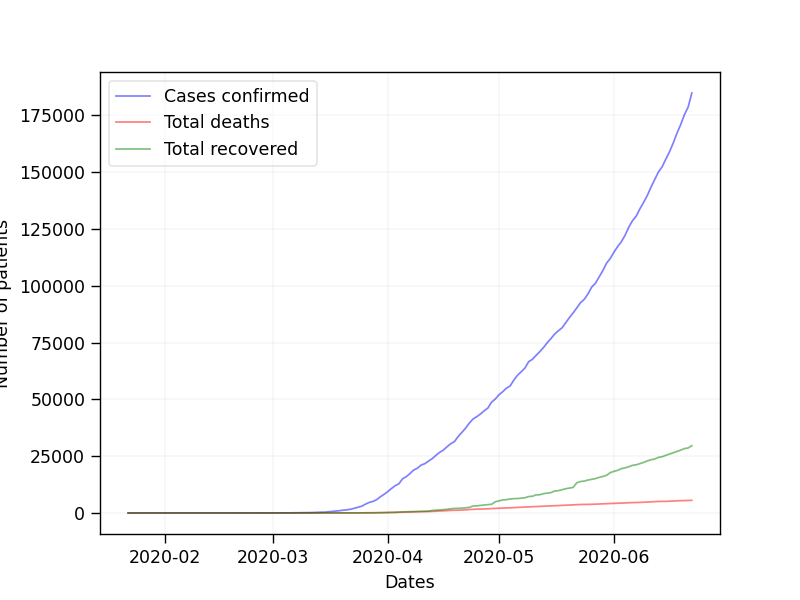

In [3]:
date = raw_data.date
C = raw_data.cases_confirmed
D = raw_data.total_deaths
R = raw_data.approx_state_rec_total

fig = plt.figure()
ax = fig.add_subplot(111, facecolor = '#ffffff', axisbelow = True)
ax.plot(date, C, 'b', alpha=0.5, lw=1, label='Cases confirmed')
ax.plot(date, D, 'r', alpha=0.5, lw=1, label='Total deaths')
ax.plot(date, R, 'g', alpha=0.5, lw=1, label='Total recovered')
ax.set_xlabel('Dates')
ax.set_ylabel('Number of patients')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
ax.yaxis.set_tick_params(length=5)
ax.xaxis.set_tick_params(length=5)
plt.grid(linewidth=0.1)
plt.show()

## Approximation of recovered patient in the state

The exact number of recovered patients in California is not available. However, the data of how many people across the country is available. We have extracted the number of patients recovered in state from this data

One assumption We have made is that the healthcare facility in all of America is same. This is not true, but We couldn't advance it any further. Now, if the healthcare facility across the country is same, then the mortality rate will also be the same. So suppose if 20% of people die, other 80% live. 

We calculated what frction of people were dying in California as oppossed to number of people dying in the whole country. And since our assumption is that mortality rate is same across the country, the same fraction of people whill be recovering in California as oppossed to the number of people getting recovered in the whole contry.

# What is SIR Model?
SIR model is a simple mathematical model to understand outbreak of infectious diseases.  

 * S: Susceptible (=All - Confirmed)
 * I: Infected (=Confirmed - Recovered - Deaths)
 * R: Recovered or fatal (=Recovered + Deaths)
 
Model:  
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
\end{align*}

$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery(+Mortality) rate [1/min]  

Ordinary Differential Equation (ODE):  
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - \gamma I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
\end{align*}

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

## SIR plotting of the given data

During the last census in California, the population was estimated to be around 40M. We will use the figure 40,000,000 for the starting population of California

<IPython.core.display.Javascript object>


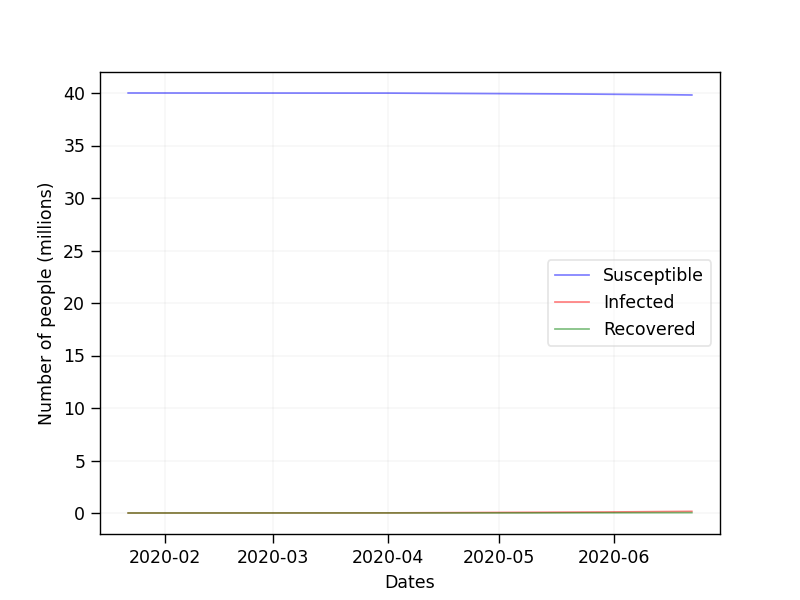

In [4]:
date = raw_data.date
N = population
I = raw_data.cases_confirmed - raw_data.approx_state_rec_total
R = raw_data.approx_state_rec_total + raw_data.total_deaths
S = N-I-R

fig = plt.figure()
ax = fig.add_subplot(111, facecolor = '#ffffff', axisbelow = True)
ax.plot(date, S/1000000, 'b', alpha=0.5, lw=1, label='Susceptible')
ax.plot(date, I/1000000, 'r', alpha=0.5, lw=1, label='Infected')
ax.plot(date, R/1000000, 'g', alpha=0.5, lw=1, label='Recovered')
ax.set_xlabel('Dates')
ax.set_ylabel('Number of people (millions)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
ax.yaxis.set_tick_params(length=5)
ax.xaxis.set_tick_params(length=5)
plt.grid(linewidth=0.1)
plt.show()

As you can see, the curve is extremely flattened as the Epidemic has just begun in California. So it is difficult to pedit the future trend of this epidemic. Please zoom in at infected and recovered lines to view the difference clearly. 

To understand how this epidemic will progress, We will find plot a general SIR curve with variable parameter values and find the parameter values for which it fits the best.

## Example of SIR model with predefined parameters

Here We have made an example SIR model for California with $\beta=0.25$ and $\gamma=1/10$. So $R_0$ will be 2.5

<IPython.core.display.Javascript object>


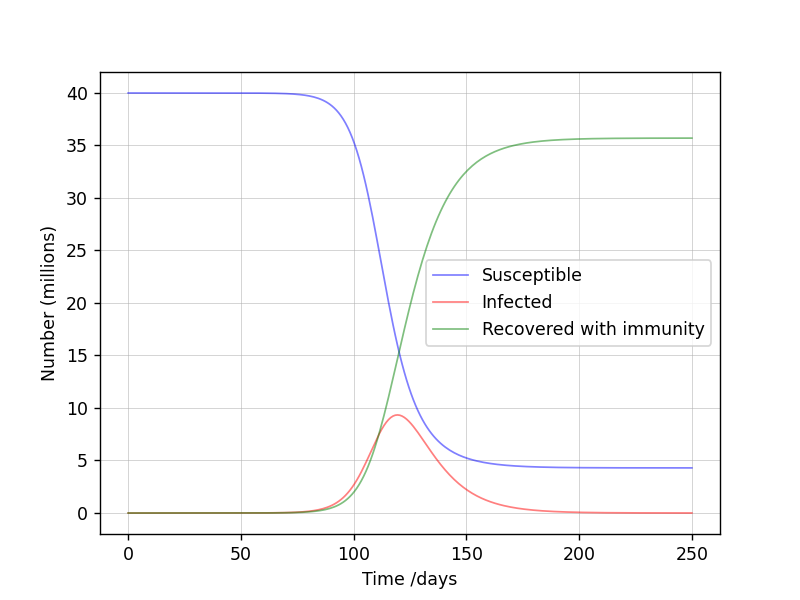

In [5]:
from scipy.integrate import odeint

# Integrating the set of differential equations
# ---------------------------------------------
N = population
I0, R0 = 1, 0
S0 = N - I0 - R0
beta, gamma = 0.25, 1./10
t = np.linspace(0, 250, 250)
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt
y0 = S0, I0, R0
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plotting the calculated graph
# -----------------------------
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#ffffff', axisbelow=True)
ax.plot(t, S/1000000, 'b', alpha=0.5, lw=1, label='Susceptible')
ax.plot(t, I/1000000, 'r', alpha=0.5, lw=1, label='Infected')
ax.plot(t, R/1000000, 'g', alpha=0.5, lw=1, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (millions)')
ax.grid(b=True, which='major', lw=0.3, ls='-')
legend = ax.legend()
plt.show()


### Now I will find a fitting SIR curve for California's condition uptil now.

Although the data for numbered of recovered patients is not accurate, We will find the value of $\beta$ and $\gamma$ for which the SIR curve fits the given data about California. We We compare the number of infected people of SIR to the number of infected people in the data obtained from JHU dataset.

In [6]:
# Number of infected people as opposed to number of day since 22-Jan-2020

y = raw_data.cases_confirmed - raw_data.approx_state_rec_total
print(y.tail(10))

143    125543.0
144    127547.0
145    130345.0
146    133019.0
147    136282.0
148    139997.0
149    143227.0
150    146877.0
151    149948.0
152    155170.0
dtype: float64


In [7]:
# I have created a test model with beta = b, gamma = y and no. of days  = t
# Now I will run a simulation for different values of b and y and find which values are best suited for the current
# state of epidemic in california.

# This code displays some warnings, so I change the setting to ignore the warning since I don't know how to remove them
import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import curve_fit

# The 'test_model' function simulates a SIR run for given 'beta' and 'gamma' values and returns the Infected data
def test_model(x, beta, gamma):
    N = population
    I0, R0 = 1, 0
    S0 = N - I0 - R0
    t = x
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    y0 = S0, I0, R0
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return I

# 'x' stores the number of days for which simulation has to run
x = raw_data.index
# curve_fit() takes in the model that I need to test and returns the most suitable values of beta and gamma as param
param, param_cov = curve_fit(test_model, x, y) 
beta, gamma = param
print("beta = ", beta)
print('gamma =', gamma)

beta =  1.1539846886009857
gamma = 1.059756164035209


<IPython.core.display.Javascript object>


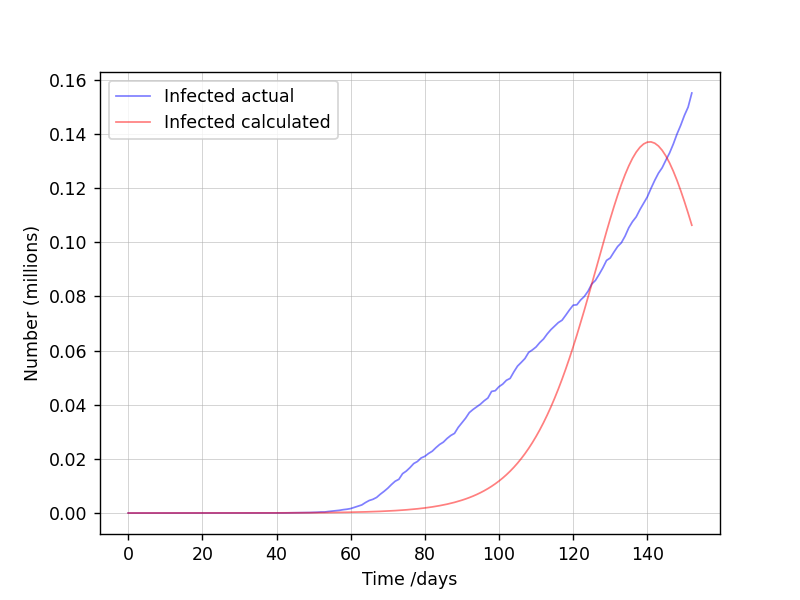

In [8]:
fig = plt.figure(facecolor='w')
t = raw_data.index
I = test_model(t, beta, gamma)
ax = fig.add_subplot(111, facecolor='#ffffff', axisbelow=True)
ax.plot(t, y/1000000, 'b', alpha=0.5, lw=1, label='Infected actual')
ax.plot(t, I/1000000, 'r', alpha=0.5, lw=1, label='Infected calculated')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (millions)')
ax.grid(b=True, which='major', lw=0.3, ls='-')
legend = ax.legend()
plt.show()

Now as you can see that this method of prediction is not very good. Now I will try another method to make simulation of SIR and predict the future trend.

## More technical way of predicting the SIR curve - Final

We are going to use <b>Scipy.optimize.minimize</b> library to create a more robust SIR model of the given data. We will be starting from more or less scratch. The library is used to minimize a quantity given some constraints and boundaries of parameters. This method was insipred from <a href='https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html'>this page's method</a>

In [9]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

#### Creating a loss error function
I will create an error function which I will try to minimize it, I will also set the boundary parameters in this case, which I coundn't last time.

In [10]:
def error(point, data):
    # RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    size = len(data)
    beta, gamma = point 
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    y0 = S0, I0, R0
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return np.sqrt(np.mean((I - data)**2))

Now I will use the minimize library to minimize the error and create a better SIR model. Since the value of $\beta$ and $\gamma$ lie between 0 and 1, I have bounded them in the program. 

In [11]:
data = pd.read_csv('data.csv').cases_confirmed - pd.read_csv('data.csv').total_deaths - pd.read_csv('data.csv').approx_state_rec_total
N = population
I0, R0 = 1, 0
S0 = N - I0 - R0
t = data.index
b = (0.00000001, 0.12)   # Change the bounds and observe how to graph at the end changes. Its interesting. 
                        # I agreed upon the current bound as it best expressed the observed trend of Covid in the state
optimal = minimize(
            error,
            [0.001, 0.001],
            args=(data),
            method='L-BFGS-B',
            bounds=[b, b]
        )
beta, gamma = optimal.x
print("beta = {} \ngamma = {} \nR_0 = {}".format(beta,gamma,beta/gamma))

beta = 0.12 
gamma = 0.0390282280291863 
R_0 = 3.0746976242493242


Plotting the new curve with the obtained beta and gamma from previous simulation

<IPython.core.display.Javascript object>


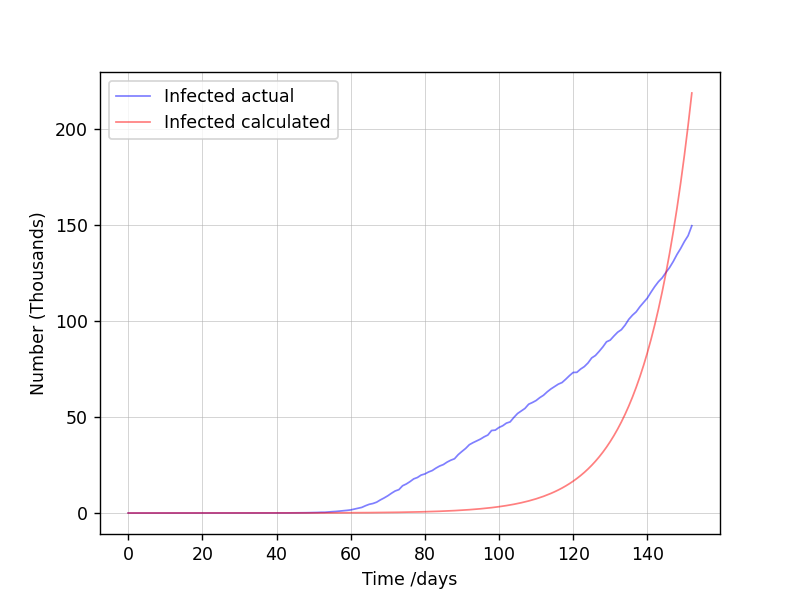

In [12]:
fig = plt.figure(facecolor='w')
t = raw_data.index
I = test_model(t, beta, gamma)
ax = fig.add_subplot(111, facecolor='#ffffff', axisbelow=True)
ax.plot(t, data/1000, 'b', alpha=0.5, lw=1, label='Infected actual')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=1, label='Infected calculated')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (Thousands)')
ax.grid(b=True, which='major', lw=0.3, ls='-')
legend = ax.legend()
plt.show()

### Here is the completely plotted data, both predicted and actually observed.

This dynamic graph requires <b>'plotly'</b> library to work. 

Please install it using '<em>pip install plotly==4.8.1</em>' or refer to <a href="https://plotly.com/python/getting-started/?utm_source=mailchimp-jan-2015&utm_medium=email&utm_campaign=generalemail-jan2015&utm_term=bubble-chart">Plotly website</a> for more information on installation.

In [13]:
# This function makes the observed and predicted data of same size so they can be plotted together
# ------------------------------------------------------------------------------------------------
def fill_remaining(S, I, R, size, req_size):
    S_filled = np.empty(req_size)
    I_filled = np.empty(req_size)
    R_filled = np.empty(req_size)
    
    S_filled[:size] = S
    I_filled[:size] = I
    R_filled[:size] = R
    
    S_filled[size:] = np.NaN
    I_filled[size:] = np.NaN
    R_filled[size:] = np.NaN
    
    S_filled = pd.Series(S_filled)
    I_filled = pd.Series(I_filled)
    R_filled = pd.Series(R_filled)
    return S_filled, I_filled, R_filled

In [14]:
# Observed and recorded data
# --------------------------
N = population
I_obs = pd.read_csv('data.csv').cases_confirmed - pd.read_csv('data.csv').total_deaths - pd.read_csv('data.csv').approx_state_rec_total
R_obs = pd.read_csv('data.csv').approx_state_rec_total + pd.read_csv('data.csv').total_deaths
S_obs = N - I_obs - R_obs
size = I_obs.size

# Plot the trend for nest 500 days
t = np.linspace(0, 500, 500)

S_obs, I_obs, R_obs = fill_remaining(S_obs, I_obs, R_obs, size, t.size)

In [15]:
# Using the obtained beta and gamma to predict next 500 days trend 
# ----------------------------------------------------------------
N = population
I0, R0 = 1, 0
S0 = N - I0 - R0
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt
y0 = S0, I0, R0
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S_pred, I_pred, R_pred = ret.T

The following is a dynamic graph by 'plotly'. Use <b>'compare data on hover'</b> tool to view and compare data of SIR model trend. Use the other tools like 'spike lines' as you see fit.

In [16]:
import plotly.graph_objects as go 

fig = go.Figure()

fig.add_trace(go.Scatter(x=t, y=S_obs/1000000, name='Susc. Observed', 
                         line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=t, y=I_obs/1000000, name='Inf. Observed', 
                         line=dict(color='red', width=1)))
fig.add_trace(go.Scatter(x=t, y=R_obs/1000000, name='Rec. Observed', 
                         line=dict(color='green', width=1)))


fig.add_trace(go.Scatter(x=t, y=S_pred/1000000, name='Susc. Predicting', 
                         line=dict(color='blue', width=1, dash='dash')))
fig.add_trace(go.Scatter(x=t, y=I_pred/1000000, name='Inf. Predicting', 
                         line=dict(color='red', width=1, dash='dash')))
fig.add_trace(go.Scatter(x=t, y=R_pred/1000000, name='Rec.predicting', 
                         line=dict(color='green', width=1, dash='dash')))

fig.update_layout(title='Complete observed and predicted data',
                   xaxis_title='No. of days starting from 22-Jan-2020',
                   yaxis_title='No. of people (millions)')

fig.show()